In [1]:
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import random
import netCDF4 as nc
from scipy.spatial import cKDTree
import seaborn as sns  

In [ ]:
#SINMOD features first :-) 

In [31]:
#Load transformed (SINMOD grid) coral data
coral_filepath = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_sinmod_grid.parquet'
coral_data = pd.read_parquet(coral_filepath)

coral_x = coral_data['x']
coral_y = coral_data['y']

In [32]:
#Load SINMOD data 
filename_sinmod = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/PhysStates_2019.nc'

sinmod_data = Dataset(filename_sinmod, 'r')


In [33]:
#Load data for stat. northness and eastness
filename_jan_jun = '/cluster/projects/itk-SINMOD/coral-mapping/midnor/samp_2D_jan_jun.nc'

jan_jun_data = Dataset(filename_jan_jun, 'r')


In [43]:
#Now plot a histogram for a chosen feature at coral data points 

def plot_histogram_at_coral_points(netcdf_data, coral_data, variable_name, t_range, jan_jun_data=False, current_aspect_angle=False, generate_random=False):
    
    zc = netcdf_data.variables['LayerDepths'][:]
    cumulative_depth = np.cumsum(zc, axis=0)

    xc_max = netcdf_data.variables['xc'].shape[0]
    yc_max = netcdf_data.variables['yc'].shape[0]

    hor_res = netcdf_data.variables['grid_mapping'].getncattr('horizontal_resolution')

    t_start, t_stop = t_range

    #Extract variable values at coral data points
    coral_values = []
    valid_coordinates = []

    for time in range(t_start, t_stop):

        for x, y in zip(coral_data['x']/hor_res, coral_data['y']/hor_res):
            
            #Ensure the coordinates are within the grid bounds
            if 0 <= x <= xc_max and 0 <= y <= yc_max:

                depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                layer_index = np.searchsorted(cumulative_depth, depth_at_point)

                if variable_name == 'current_speed':
                    value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)

                elif variable_name in ['statistical_eastness', 'statistical_northness']:
                    longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')
                    longitude_at_point = jan_jun_data.variables['gridLons'][int(y), int(x)]
                    theta = longitude_at_point - longitude_of_projection_origin
                    eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                    northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                    aspect = np.arctan2(eastward_velocity, northward_velocity)
                    
                    if variable_name == 'statistical_eastness':
                        value = np.sin(aspect)
                    else:
                        value = np.cos(aspect)
                        
                elif variable_name == 'current_aspect_angle':
                    try:
                        value = current_aspect_angle.variables[int(y), int(x)]
                    except KeyError:
                        value = np.nan  

                else:
                    value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                if not np.ma.is_masked(value):
                    coral_values.append(value)
                    valid_coordinates.append((int(x), int(y)))

    #Convert list to numpy array for easier manipulation
    coral_values = np.array(coral_values)

    #Flatten the array to combine all time steps
    coral_values_flat = coral_values.flatten()

    #Plot histogram of the combined variable values

    plt.hist(coral_values_flat, bins=20, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}', fontsize = 14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points (Combined Time Steps)', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.show()
    #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/{variable_name.capitalize()}_histogram_coral_points.png')
 

    print(f"Number of valid coordinates: {len(valid_coordinates)/(t_stop - t_start)} out of {len(coral_data)}")

    if generate_random:
        #Plotting histogram at random locations
        
        no_points = int(len(valid_coordinates)/(t_stop - t_start))

        #Generate same number of valid co-ords as random x and y locations within the grid
        valid_xc_yc_indices = np.argwhere(np.logical_and(~netcdf_data.variables['temperature'][0,0].mask, netcdf_data.variables['depth'][:] <=275,  netcdf_data.variables['depth'][:] >= 150))

        selected_indices = valid_xc_yc_indices[np.random.choice(valid_xc_yc_indices.shape[0], size=no_points, replace=False)]

        random_values = []
        random_valid_coordinates = 0

        for time in range(t_start, t_stop):

            for y, x in selected_indices:
                if 0 <= x <= xc_max and 0 <= y <= yc_max:
                    depth_at_point = netcdf_data.variables['depth'][int(y), int(x)]
                    random_depth = random.uniform(100, depth_at_point)
                    layer_index = np.searchsorted(cumulative_depth, random_depth)

                    if variable_name == 'current_speed':
                        value = np.sqrt(netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)]**2 + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)]**2)

                    elif variable_name in ['statistical_eastness', 'statistical_northness']:
                        longitude_of_projection_origin = netcdf_data.variables['grid_mapping'].getncattr('longitude_of_projection_origin')
                        longitude_at_point = jan_jun_data.variables['gridLons'][int(y), int(x)]
                        theta = longitude_at_point - longitude_of_projection_origin
                        eastward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta)) - netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta))
                        northward_velocity = netcdf_data.variables['u_velocity'][time, layer_index, int(y), int(x)] * np.sin(np.deg2rad(theta)) + netcdf_data.variables['v_velocity'][time, layer_index, int(y), int(x)] * np.cos(np.deg2rad(theta))
                        aspect = np.arctan2(eastward_velocity, northward_velocity)
                    
                        if variable_name == 'statistical_eastness':
                            value = np.sin(aspect)
                        else:
                            value = np.cos(aspect)
                            
                    elif variable_name == 'current_aspect_angle':
                        try:
                            value = current_aspect_angle.variables[int(y), int(x)]
                        except KeyError:
                            value = np.nan  
                       
                    else:
                        value = netcdf_data.variables[variable_name][time, layer_index, int(y), int(x)]

                    if not np.ma.is_masked(value):
                        random_values.append(value)
                        random_valid_coordinates += 1
        
        #Convert list to numpy array for easier manipulation
        random_values = np.array(random_values)

        #Flatten the array to combine all time steps
        random_values_flat = random_values.copy().flatten()

        #Plot histogram at random points
        plt.hist(random_values_flat, bins=20, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}', fontsize = 14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values (Combined Time Steps)', fontsize=16)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.show()
        #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/{variable_name.capitalize()}_histogram_random_points.png')

        print(f"Number of valid random coordinates: {random_valid_coordinates/(t_stop - t_start)} out of {len(coral_data)}")

        #Calculate statistics for coral values
        stats = {
            'mean': np.mean(coral_values_flat),
            'max': np.max(coral_values_flat),
            'min': np.min(coral_values_flat),
            '90th_percentile': np.percentile(coral_values_flat, 90),
            '10th_percentile': np.percentile(coral_values_flat, 10),
            'std': np.std(coral_values_flat, ddof=1), #std
            'cv': np.std(coral_values_flat, ddof=1) / np.mean(coral_values_flat) if np.mean(coral_values_flat) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for coral values: {stats}")


        #Histogram of coral and random points combined
        bin_edges = np.histogram_bin_edges(np.concatenate([random_values_flat, coral_values_flat]), bins=40)
        plt.figure(figsize=(10, 6))
        plt.hist(random_values_flat, bins=bin_edges, edgecolor='black', color='red', alpha=0.6, label='Random Points')
        plt.hist(coral_values_flat, bins=bin_edges, edgecolor='black', color='blue', alpha=0.6, label='Coral Points')
        plt.legend(loc='upper right')
        plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
        plt.ylabel('Frequency', fontsize=14) 
        plt.title(f'Combined Histogram of Coral and Random Points ({variable_name.capitalize()})', fontsize=16)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.tight_layout()
        plt.show()


        #KDE line plots for both random and coral points combined
        plt.figure(figsize=(10, 6))
        sns.kdeplot(random_values_flat, color='red', lw=2, label='Random Points')
        sns.kdeplot(coral_values_flat, color='blue', lw=2, label='Coral Points')
        plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
        plt.ylabel('Density', fontsize=14)  
        plt.title(f'KDE of Coral and Random Points ({variable_name.capitalize()})', fontsize=16)
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.tight_layout()
        plt.show()
    return coral_values, random_values


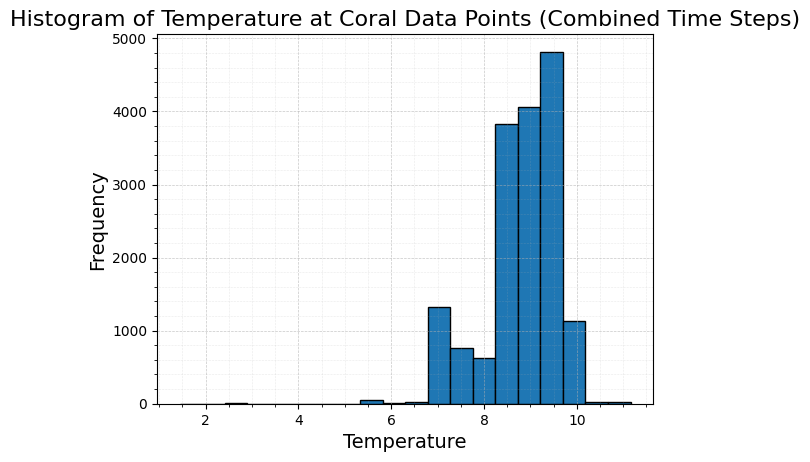

Number of valid coordinates: 836.0 out of 1718


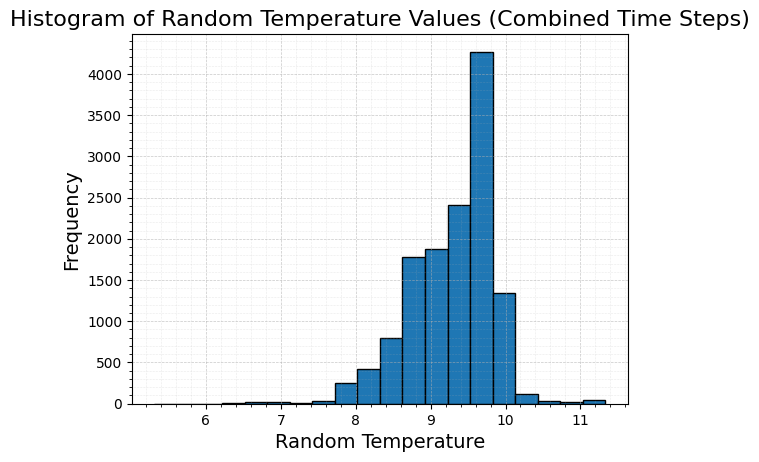

Number of valid random coordinates: 672.1 out of 1718
Statistics for coral values: {'mean': np.float32(8.807966), 'max': np.float32(11.155919), 'min': np.float32(1.4389477), '90th_percentile': np.float32(9.649098), '10th_percentile': np.float32(7.44084), 'std': np.float32(0.8146678), 'cv': np.float32(0.09249216)}


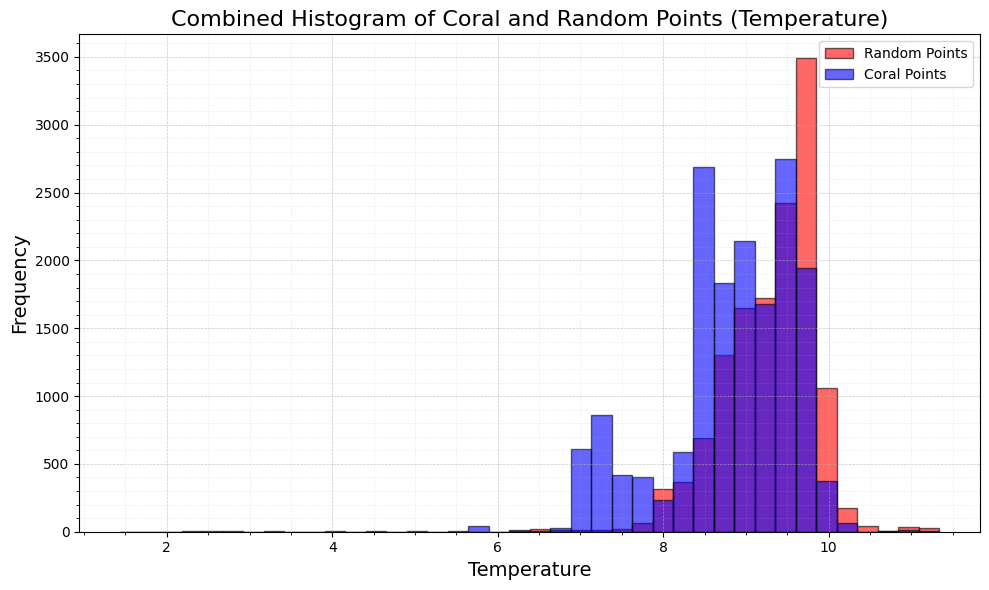

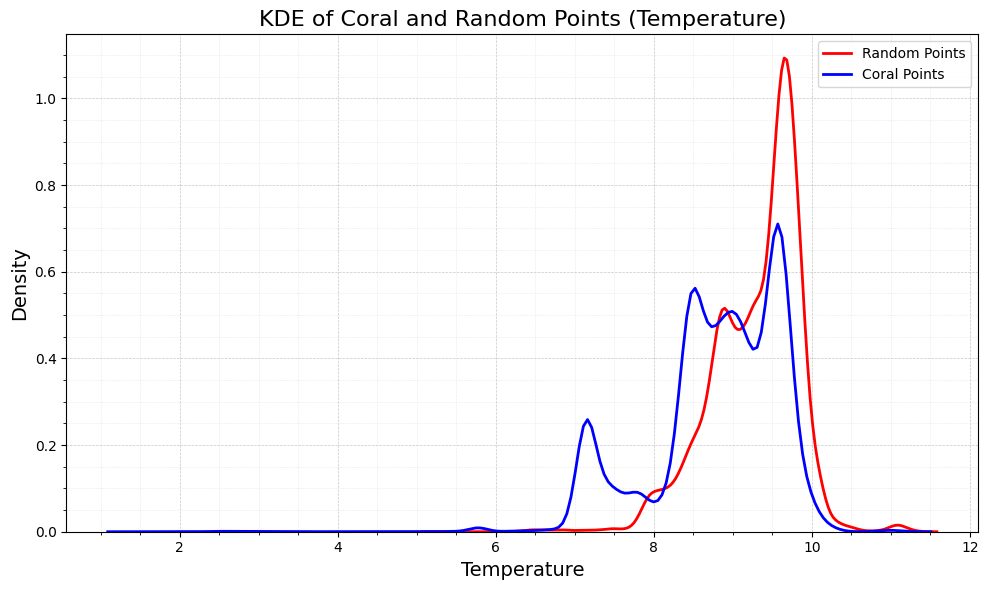

In [44]:
#Plot histograms for desired features
#tmax = len(sinmod_data.variables['time'])
tmax = 20

#coral_values_salinity, random_values_salinity = plot_histogram_at_coral_points(sinmod_data, coral_data, 'salinity', (0, tmax), False, False, True)
#coral_values_stat_north, random_values_stat_northness = plot_histogram_at_coral_points(sinmod_data, coral_data, 'statistical_northness', (0, tmax), jan_jun_data, False, True)
#coral_values_stat_eastness, random_values_stat_eastness = plot_histogram_at_coral_points(sinmod_data, coral_data, 'statistical_eastness', (0, tmax), jan_jun_data, False, True)
#coral_values_current_speed, random_values_current_speed = plot_histogram_at_coral_points(sinmod_data, coral_data, 'current_speed', (0, tmax), False, False, True)
coral_values_temperature, random_values_temperature = plot_histogram_at_coral_points(sinmod_data, coral_data, 'temperature', (0, tmax), False, False, True)



In [40]:
#Box plots 
def plot_comparison_boxplots(coral_values, random_values, variable_name):
    
    data = [coral_values, random_values]
    labels = ['Coral Values', 'Random Values']

    plt.figure(figsize=(10, 6))
    plt.boxplot(data, tick_labels=labels)
    plt.xticks(fontsize=14) 
    plt.ylabel(variable_name.capitalize(), fontsize=14)
    plt.title(f'Comparison of {variable_name.capitalize()} at Coral Data Points and Random Locations', fontsize=16)
    plt.minorticks_on()  # Enable minor ticks
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Control grid appearance
    #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/boxplots/{variable_name}_comparison_boxplot.png')
    plt.show()


In [ ]:
#Plot boxplots for desired features
#plot_comparison_boxplots(coral_values_salinity, random_values_salinity, 'salinity')
#plot_comparison_boxplots(coral_values_stat_north, random_values_stat_north, 'statistical_northness')
#plot_comparison_boxplots(coral_values_stat_eastness, random_values_stat_eastness, 'statistical_eastness')
#plot_comparison_boxplots(coral_values_current_speed, random_values_current_speed, 'current_speed')
#plot_comparison_boxplots(coral_values_temperature, random_values_temperature, 'temperature')

In [ ]:
#Next EMOD features

In [10]:
#Load transformed (EMOD grid) coral data
coral_filepath_emod = '/cluster/home/maikents/features_midnor_2019/coral_data/midnor_coral_data_emod_grid.parquet'
coral_data_emod = pd.read_parquet(coral_filepath_emod)

coral_x_emod = coral_data_emod['x']
coral_y_emod = coral_data_emod['y']

In [11]:
print(coral_data_emod.head())

               x             y
0  541563.035108  7.183257e+06
1  574769.093767  7.053834e+06
2  448510.482064  7.072666e+06
3  518562.649871  7.129859e+06
4  475671.223693  7.111198e+06


In [3]:
#Load EMOD data
emod_data = xr.open_dataset("/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/EMOD_features.nc")
emod_data_copy = emod_data.copy()

In [4]:
#Handle the EMOD data 
emod_df = emod_data_copy.to_dataframe()
emod_df = emod_df.reset_index()
emod_df['y'] = emod_df['y'].round().astype(int)
emod_df['x'] = emod_df['x'].round().astype(int)
emod_df = emod_df.set_index(['y', 'x'])
nan_indices = emod_df[emod_df['bathymetry'].isna()].index
emod_df_cleaned = emod_df.dropna(subset=['bathymetry'])
emod_df = emod_df_cleaned.sort_values(by="y")

In [13]:
#Current aspect angle
sinmod_bottom = xr.open_dataset('/cluster/projects/itk-SINMOD/coral-mapping/data/processed_data/features/ready-for-training/SINMOD_bottom_features.nc')
current_aspect_angle = sinmod_bottom['current_aspect_angle']

In [14]:
current_df = current_aspect_angle.to_dataframe()

In [15]:
current_df_cleaned = current_df.dropna(subset=['current_aspect_angle'])


In [5]:
#Histograms for EMOD data
def plot_histogram_at_coral_points_emod(emod_df, coral_data, variable_name, generate_random=False):
    
    coral_values = []
    valid_coords = []
    xc_max = 692028
    yc_max = 7539188
    x_indices = np.clip(np.round(coral_data['x']).astype(int), -65456, xc_max - 1)
    y_indices = np.clip(np.round(coral_data['y']).astype(int), 6659218, yc_max - 1)

    emod_df.index = emod_df.index.map(lambda index: (round(index[0]), round(index[1])))

    df_y_values = np.array(emod_df.index.get_level_values(0))
    df_x_values = np.array(emod_df.index.get_level_values(1))

    for x, y in zip(x_indices, y_indices):
    
        if (y, x) in emod_df.index:
            closest_y, closest_x = y, x
        else:
            # Find the closest available indices in df
            closest_y = df_y_values[np.abs(df_y_values - y).argmin()]
            closest_x = df_x_values[np.abs(df_x_values - x).argmin()]

        if (closest_y, closest_x) in emod_df.index:
            value = emod_df.loc[(closest_y, closest_x)][variable_name]
            if not np.ma.is_masked(value):
                if (closest_y, closest_x) not in valid_coords:
                    coral_values.append(value)
                    valid_coords.append((closest_y, closest_x))

    coral_values_flat = np.ravel(coral_values)
    values = pd.DataFrame({f'{variable_name}': coral_values_flat})

    values = values[variable_name].dropna().values

    #Plot histogram of the combined variable values
    
    bin_edges = np.histogram_bin_edges(values, bins=20)
    plt.hist(values, bins=bin_edges, edgecolor='black')
    plt.xlabel(f'{variable_name.capitalize()}', fontsize = 14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title(f'Histogram of {variable_name.capitalize()} at Coral Data Points (Combined Time Steps)', fontsize=16)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
    plt.show()
    #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/EMOD/{variable_name.capitalize()}_histogram_coral_points.png')
 
    print(f"Number of valid coordinates: {len(valid_coords)} out of {len(coral_data)}")

    if len(values) == 0:
        print("Error: array is empty after dropping NaNs!")
    else:

        #Calculate statistics for coral values
        stats = {
            'mean': np.mean(values),
            'max': np.max(values),
            'min': np.min(values),
            '90th_percentile': np.percentile(values, 90),
            '10th_percentile': np.percentile(values, 10),
            'std': np.std(values, ddof=1), #std
            'cv': np.std(values, ddof=1) / np.mean(values) if np.mean(values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }
       
        print(f"Statistics for {variable_name}:", stats)


    if generate_random:
        variable_data = emod_df[variable_name]
        valid_data = variable_data.dropna()
        no_points = int(len(valid_coords))
        random_indices = np.random.choice(valid_data.index, no_points, replace=False)
        random_values = emod_df.loc[random_indices, variable_name]

        #Plot histogram at random points
        plt.hist(random_values, bins=20, edgecolor='black')
        plt.xlabel(f'Random {variable_name.capitalize()}', fontsize = 14)
        plt.ylabel('Frequency', fontsize=14)
        plt.title(f'Histogram of Random {variable_name.capitalize()} Values (Combined Time Steps)', fontsize=16)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7) 
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.show()
        #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/histograms/EMOD/{variable_name.capitalize()}_histogram_random_points.png')

        #print(f"Number of valid random coordinates: {random_valid_coordinates} out of {len(coral_data)}")

        #Calculate statistics for coral values
        random_stats = {
            'mean': np.mean(random_values),
            'max': np.max(random_values),
            'min': np.min(random_values),
            '90th_percentile': np.percentile(random_values, 90),
            '10th_percentile': np.percentile(random_values, 10),
            'std': np.std(random_values, ddof=1), #std
            'cv': np.std(random_values, ddof=1) / np.mean(random_values) if np.mean(random_values) != 0 else np.nan #Coefficient of Variation: Standard deviation as a percentage of the mean, useful for comparing variability across datasets.  
        }

        print(f"Statistics for random values: {random_stats}")

        #Plot combined histogram for both coral and random points
        bin_edges = np.histogram_bin_edges(np.concatenate([random_values, values]), bins=40)
        plt.figure(figsize=(10, 6))
        plt.hist(random_values, bins=bin_edges, edgecolor='black', color='red', alpha=0.6, label='Random Points')
        plt.hist(values, bins=bin_edges, edgecolor='black', color='blue', alpha=0.6, label='Coral Points')
        plt.legend(loc='upper right')
        plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
        plt.ylabel('Frequency', fontsize=14) 
        plt.title(f'Combined Histogram of Coral and Random Points ({variable_name.capitalize()})', fontsize=16)
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.tight_layout()
        plt.show()

        #KDE (Kernel Density Estimate) line plots for both random and coral points combined
        plt.figure(figsize=(10, 6))
        sns.kdeplot(random_values, color='red', lw=2, label='Random Points')
        sns.kdeplot(values, color='blue', lw=2, label='Coral Points')
        plt.xlabel(f'{variable_name.capitalize()}', fontsize=14)
        plt.ylabel('Density', fontsize=14)  
        plt.title(f'KDE of Coral and Random Points ({variable_name.capitalize()})', fontsize=16)
        plt.legend(loc='upper right')
        plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
        plt.minorticks_on()
        plt.grid(which='minor', linestyle=':', linewidth=0.4, alpha=0.5)
        plt.tight_layout()
        plt.show()
    return values, random_values




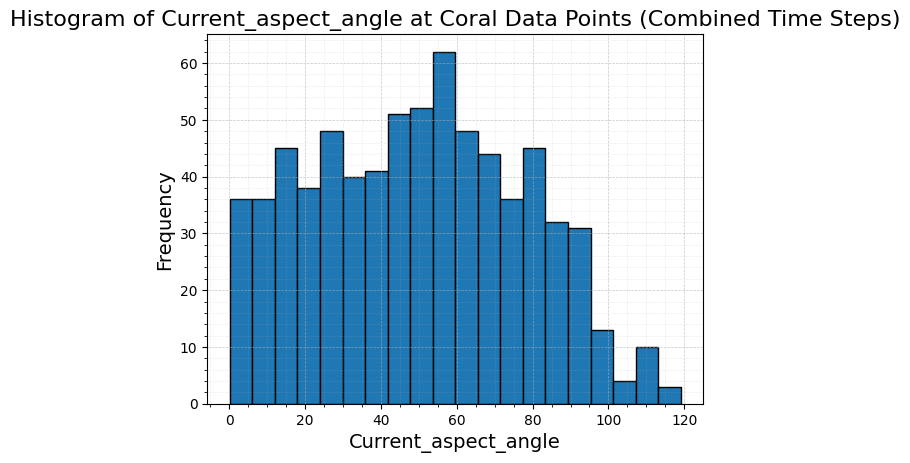

Number of valid coordinates: 715 out of 841
Statistics for current_aspect_angle: {'mean': np.float64(49.79114328387531), 'max': np.float64(119.04370735908456), 'min': np.float64(0.18736109645549717), '90th_percentile': np.float64(86.68523178229196), '10th_percentile': np.float64(12.047915805344477), 'std': np.float64(27.64367583673511), 'cv': np.float64(0.5551926309289512)}


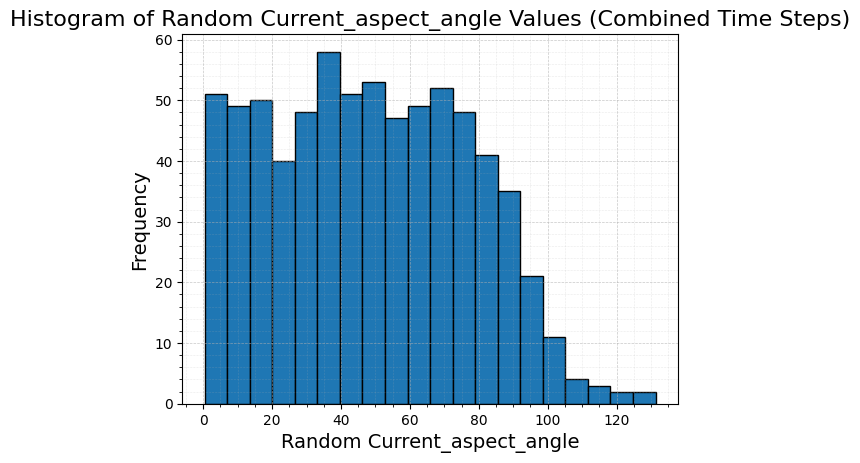

Statistics for random values: {'mean': np.float64(48.4065417720587), 'max': np.float64(131.32639239983976), 'min': np.float64(0.4302396383872488), '90th_percentile': np.float64(86.27602013725965), '10th_percentile': np.float64(9.528772123712756), 'std': np.float64(28.474909366540015), 'cv': np.float64(0.5882450661446826)}


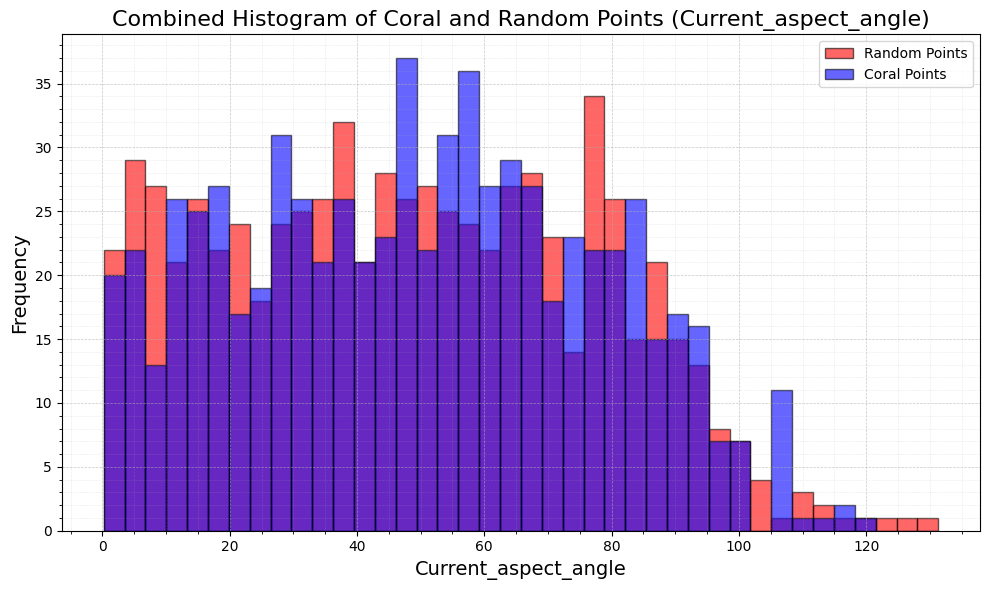

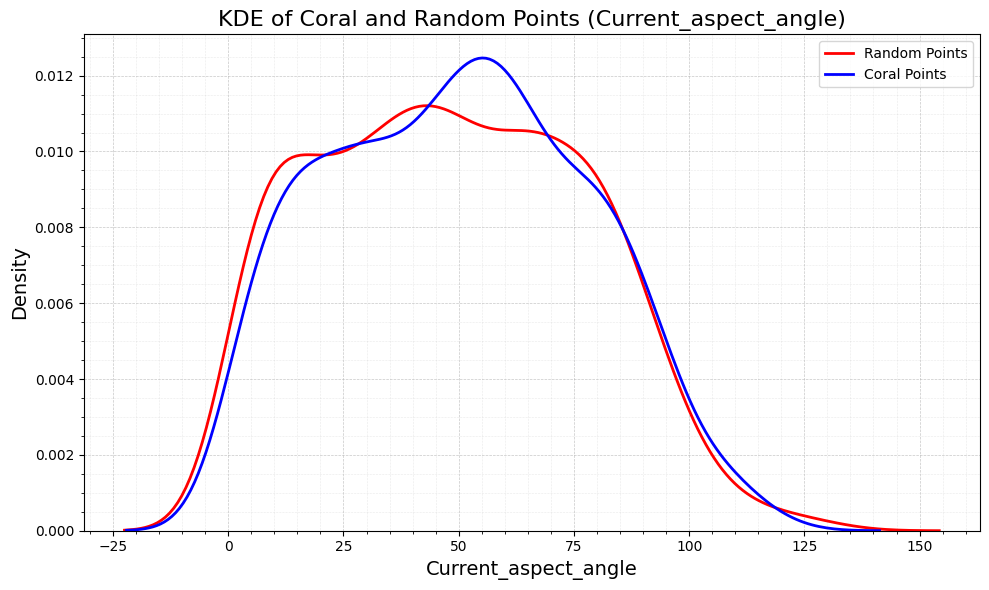

In [16]:
#Repeat for desired features
#values_bathymetry, random_values_bathymetry = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'bathymetry', True)
#values_aspect_cos, random_values_aspect_cos = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'aspect_cos', True)
#values_aspect_sin, random_values_aspect_sin = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'aspect_sin', True)
#values_broad_BPI, random_values_broad_BPI = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'broad_BPI', True)
#values_fine_BPI, random_values_fine_BPI = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'fine_BPI', True)
#values_log_ruggedness, random_values_log_ruggedness = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'log_ruggedness', True)
#values_slope, random_values_slope = plot_histogram_at_coral_points_emod(emod_df, coral_data_emod, 'slope', True)
#values_current_aspect_angle, random_values_current_aspect_angle= plot_histogram_at_coral_points_emod(current_df_cleaned, coral_data_emod, 'current_aspect_angle', True)



In [21]:
#Box plots 
def plot_comparison_boxplots_emod(coral_values, random_values, variable_name):
    
    coral_values_clean = coral_values[~np.isnan(coral_values)]
    random_values_clean = random_values[~np.isnan(random_values)]

    data = [coral_values_clean, random_values_clean]
    labels = ['Coral Values', 'Random Values']

    if coral_values_clean.size > 0 and random_values_clean.size > 0:
        plt.figure(figsize=(10, 6))
        plt.boxplot(data, tick_labels=labels)
        plt.xticks(fontsize=14) 
        plt.ylabel(variable_name.capitalize(), fontsize=14)
        plt.title(f'Comparison of {variable_name.capitalize()} at Coral Data Points and Random Locations', fontsize=16)
        plt.minorticks_on()  # Enable minor ticks
        plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, alpha=0.7)  # Control grid appearance
        #plt.savefig(f'/cluster/home/maikents/features_midnor_2019/boxplots/{variable_name}_comparison_boxplot.png')
        plt.show()


    else:
        print("No valid data points for the boxplot.")


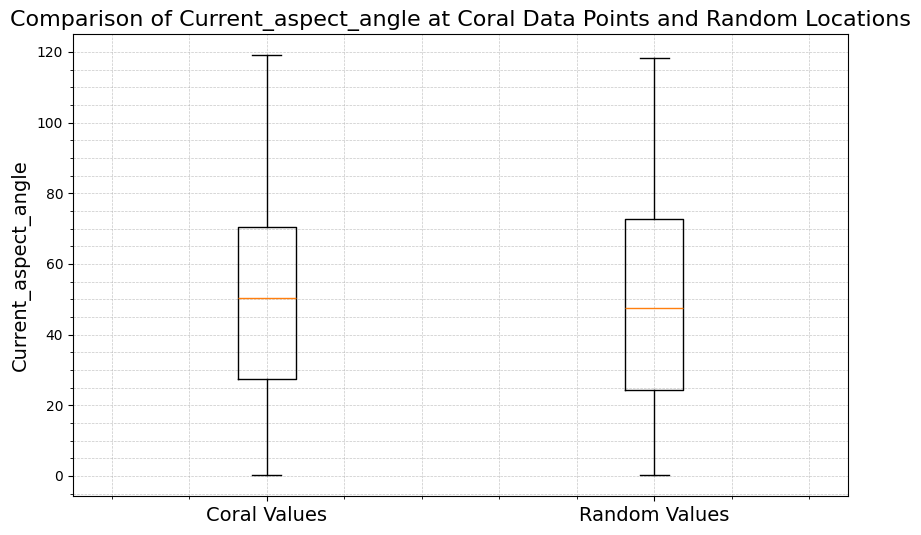

In [44]:
#Plot boxplots for desired features
#plot_comparison_boxplots_emod(values_bathymetry, random_values_bathymetry, 'bathymetry')
#plot_comparison_boxplots_emod(values_aspect_cos, random_values_aspect_cos, 'aspect_cos')
#plot_comparison_boxplots_emod(values_aspect_sin, random_values_aspect_sin, 'aspect_sin')
#plot_comparison_boxplots_emod(values_broad_BPI, random_values_broad_BPI, 'broad_BPI')
#plot_comparison_boxplots_emod(values_fine_BPI, random_values_fine_BPI, 'fine_BPI')
#plot_comparison_boxplots_emod(values_log_ruggedness, random_values_log_ruggedness, 'log_ruggedness')
#plot_comparison_boxplots_emod(values_slope, random_values_slope, 'slope')
plot_comparison_boxplots_emod(values_current_aspect_angle, random_values_current_aspect_angle, 'current_aspect_angle')


In [7]:
#Chlorophyll data
chlor = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/midnor_chlorophyll_emod_grid.nc')
print(chlor)

<xarray.Dataset> Size: 337MB
Dimensions:  (time: 1081, lat: 191, lon: 407)
Coordinates:
  * lat      (lat) float32 764B 67.94 67.9 67.85 67.81 ... 60.1 60.06 60.02
  * lon      (lon) float32 2kB -1.896 -1.854 -1.812 -1.771 ... 14.94 14.98 15.02
    x        (lat, lon) float64 622kB ...
    y        (lat, lon) float64 622kB ...
Dimensions without coordinates: time
Data variables:
    chlor_a  (time, lat, lon) float32 336MB ...


In [9]:
import xarray as xr
import pandas as pd

# Load the dataset
chlor = xr.open_dataset('/cluster/home/maikents/features_midnor_2019/midnor_chlorophyll_emod_grid.nc')

# Reshape the data for chlor_a
# Stack the time, lat, and lon dimensions into a single multi-index
chlor_data = chlor['chlor_a'].stack(z=('time', 'lat', 'lon'))

ValueError: cannot insert lon, already exists